In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns

# UMap
import umap
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm

import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import umap.plot

In [2]:
data = pd.read_csv('usc_seating_data.csv', encoding='utf-8')

In [3]:
data['Abstract 1'] = data['Abstract 1'].fillna(' ')
data['Abstract 2'] = data['Abstract 2'].fillna(' ')
data['Abstract 3'] = data['Abstract 3'].fillna(' ')

In [4]:
data['added_abstracts'] = data['Abstract 1'] + ' ' + data['Abstract 2'] + ' ' + data['Abstract 3']
data = data[data['Random'] != 'yes']
data = data[data['Skip'] != 'yes']

In [5]:
data_cleaned = data[['First name', 'Last Name', 'School', 'Category', 'PhD', 'Provided Keywords', 'Random', 'Skip', 'added_abstracts']]

In [6]:
data_cleaned

,First name,Last Name,School,Category,PhD,Provided Keywords,Random,Skip,added_abstracts
0,Kevin,Murphy,USC,Finance,No,NaN,NaN,NaN,Finance theory says that companies in declinin...
1,Robert,Dittmar,University of Michigan,Finance,No,Asset pricing,NaN,NaN,We conduct a systematic examination of the ret...
2,Mitch,Warachka,Chapman University,Finance,No,Innovation\nValue Creation\nCulture,NaN,NaN,A large literature reports that proximity infl...
3,William,Mullins,UC San Diego,Finance,No,"Finance, Corporate and Household finance, poli...",NaN,NaN,We find evidence of selective exposure to conf...
4,Stan,Markov,UT Dallas,Accounting,No,"social media, big data, market efficiency,\",NaN,NaN,We examine how increased competition stemming ...
...,...,...,...,...,...,...,...,...,...
73,Kristi,Rennekamp,Cornell University,Accounting,No,NaN,NaN,NaN,As firms increasingly use social media to prov...
74,Suzanne,Burzillo,USC,Accounting,Yes,NaN,NaN,NaN,Recent years have witnessed growing interest i...
75,Nick,Bloom,Stanford,Economics,No,NaN,NaN,NaN,We construct the World Uncertainty Index (WUI)...
76,Anastassia,Fedyk,Berkeley Haas,Finance,No,NaN,NaN,NaN,We study the use and economic impact of artifi...


In [7]:
corpus = data_cleaned['added_abstracts'].tolist()

In [8]:
# removes stopwords from a tokenized list
def remove_stopwords(tokens, words):
    return [token for token in tokens if token not in words]

# apply stemming to a list of tokens
def apply_stemming(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# find words <= 2 letters or >= 21 letters
def find_two_letters(tokens):
    two_letters = []
    for token in tokens:
        if len(token) <= 2 or len(token) >= 21:
            two_letters.append(token)
    return two_letters

In [9]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = find_two_letters(listOfTokens)

        listOfTokens = remove_stopwords(listOfTokens, stopwords)
        listOfTokens = remove_stopwords(listOfTokens, other_words)
        
        listOfTokens = apply_stemming(listOfTokens, param_stemmer)
        listOfTokens = remove_stopwords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alekseyvalouev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alekseyvalouev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
language = 'english'
corpus = processCorpus(corpus, language)

In [12]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
def run_kmeans(k, data):
    kmeans = cluster.KMeans(n_clusters = k, init = 'k-means++', n_init = 10, tol = 0.0001, random_state = 1, algorithm = 'full')
    return kmeans.fit(data)

In [50]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats, columns):
    plt.rcParams.update({'font.size': 2})
    
    # Compute Rows required

    rows = len(dfs) // columns 
    rows += len(dfs) % columns

    # Create a Position index

    Position = range(1, len(dfs) + 1)
    
    fig = plt.figure(1, dpi=800)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)
    
    for i in range(0, len(dfs)):
        ax = fig.add_subplot(rows,columns,Position[i])
        
        ax.set_title(("Most Common Words in Cluster {}".format(i)), fontsize=3, fontweight='bold')
        
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
    
    plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


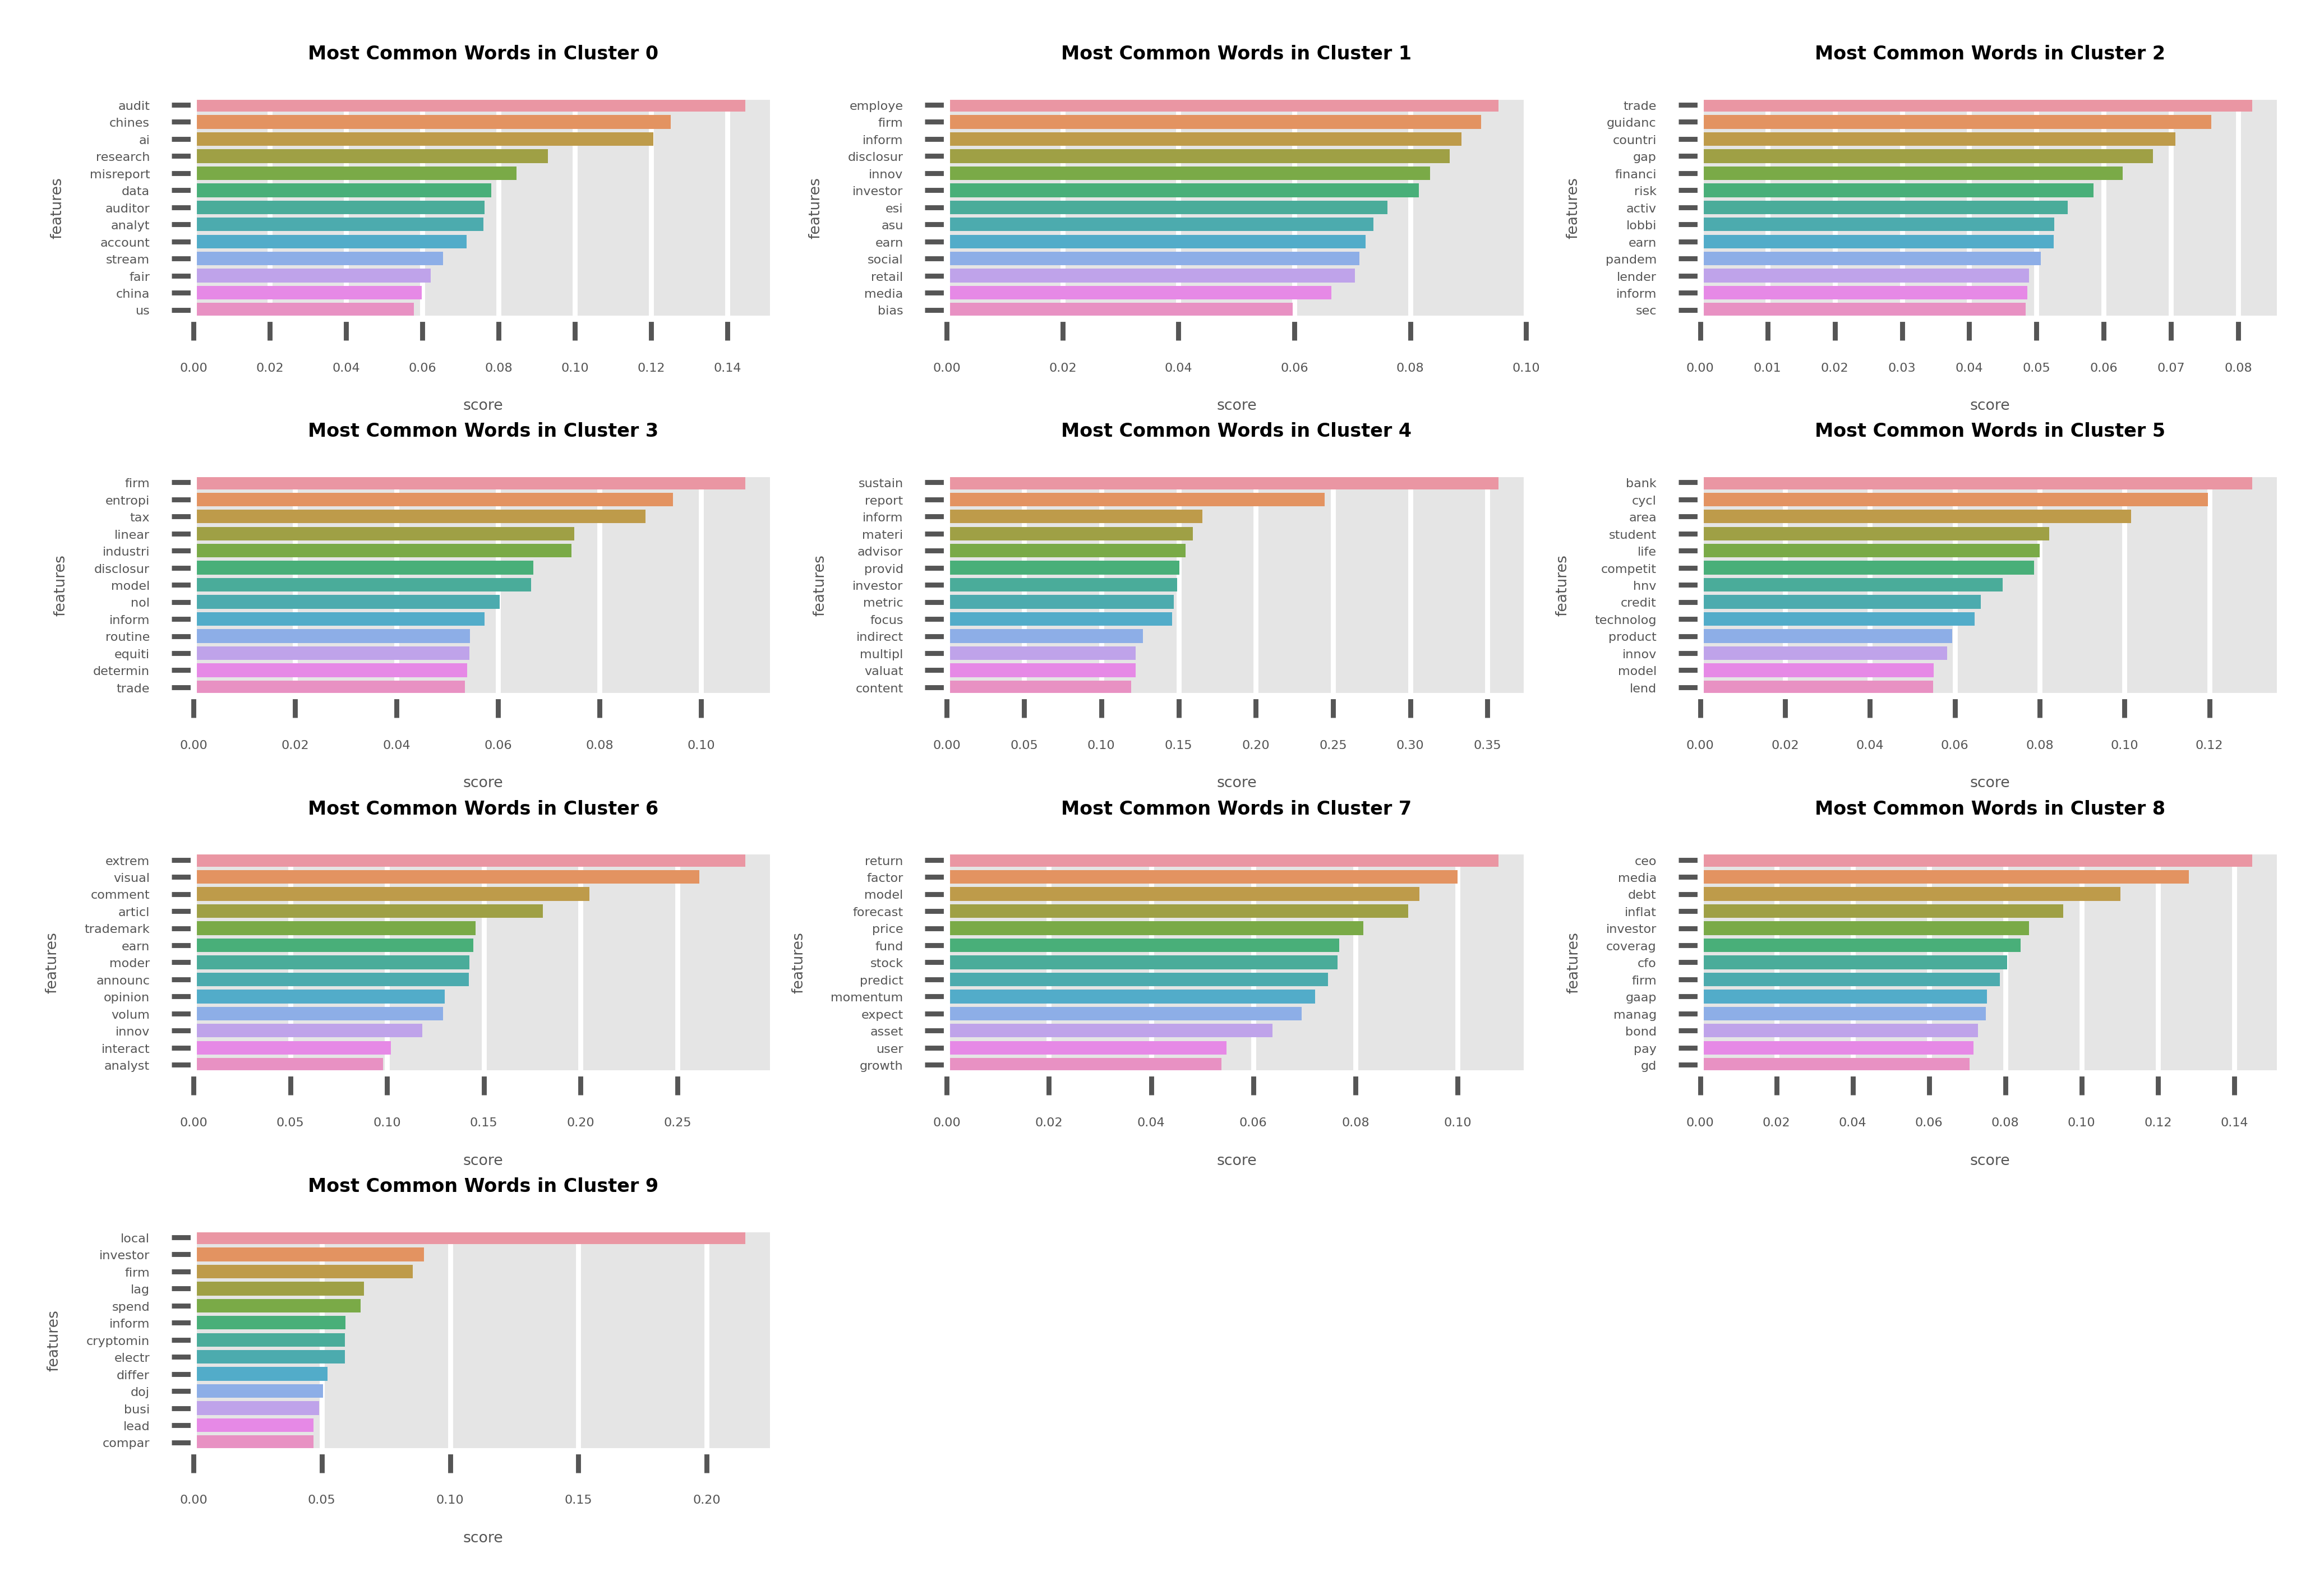

In [51]:
k = 10
kmeans = run_kmeans(k, final_df)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13, 3)

In [52]:


# We train the PCA on the dense version of the tf-idf. 
pca = PCA(n_components=2)
two_dim = pca.fit_transform(final_df)

scatter_x = two_dim[:, 0] # first principle component
scatter_y = two_dim[:, 1] # second principle component

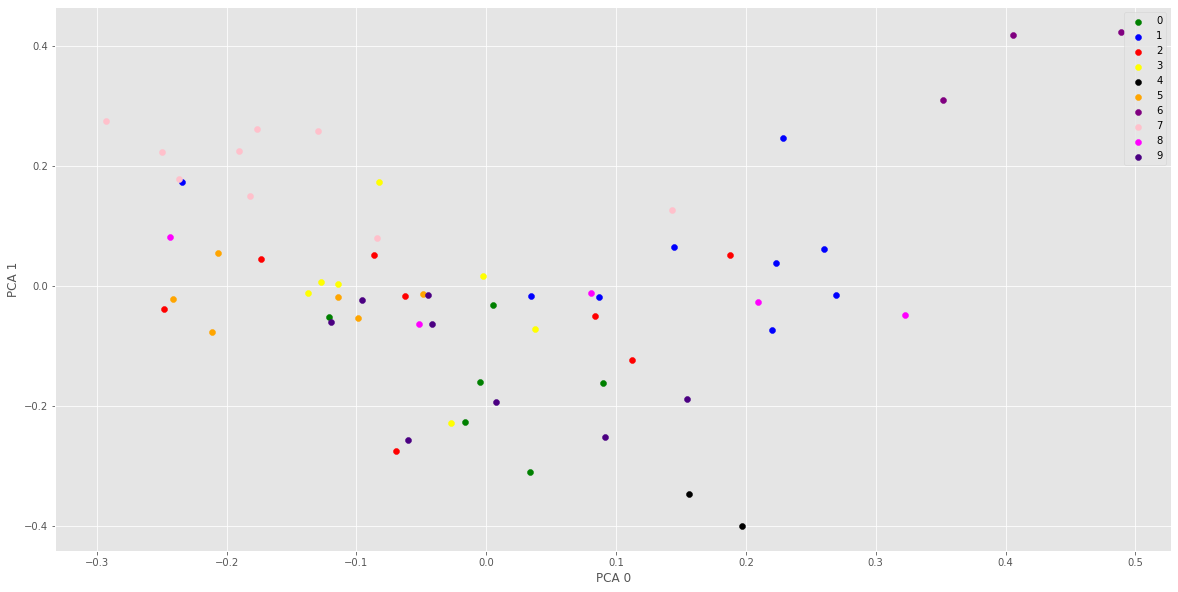

In [53]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# color map for NUMBER_OF_CLUSTERS we have
cmap = {0: 'green', 1: 'blue', 2: 'red', 3: 'yellow', 4 : 'black', 5: 'orange', 6: 'purple', 7: 'pink', 8: 'magenta', 9: 'indigo'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(prediction):
    ix = np.where(prediction == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

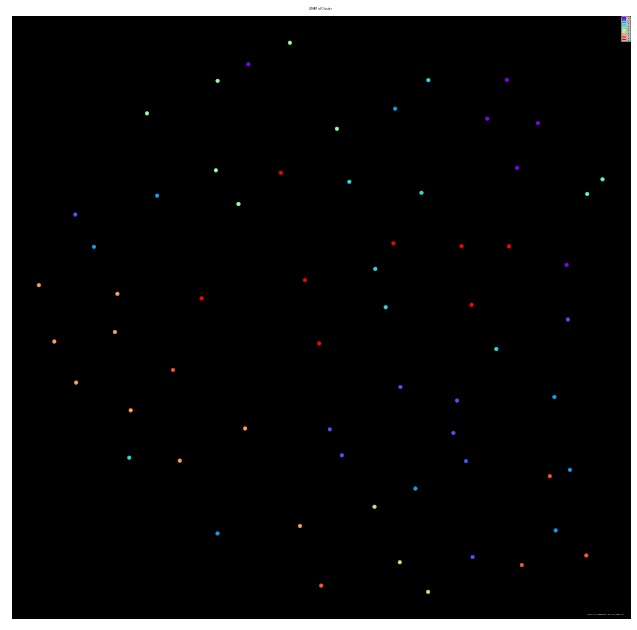

In [47]:
tfidf_embedding = umap.UMAP().fit(final_df)
fig = umap.plot.points(tfidf_embedding, labels=prediction, theme='fire')
plt.title("UMAP of Cluster")
plt.show()